# CREATE GEOMETRY and FLUXES FROM DATA

## Import

In [1]:
# A 
import ast
# C
from collections import defaultdict
# G
import gc
import geopandas as gpd
# J
import json
# M
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool
# N
from numba import prange
import numpy as np
# O
import os
# P
import pandas as pd
# S
from shapely.geometry import box,LineString,Point,MultiPoint,MultiLineString,MultiPolygon,Polygon
from shapely.ops import unary_union
import socket
import sys
# T
from termcolor import  cprint
import time

# Project specific
# A
from AlgorithmCheck import *
# C
from ComputeGrid import *
from ComputeHexagon import *
# F
current_dir = os.path.join(os.getcwd()) 
mother_path = os.path.abspath(os.path.join(current_dir, os.pardir))
print('mother_path:', mother_path)
sys.path.append(os.path.join(mother_path, 'PreProcessing'))
sys.path.append(os.path.join(mother_path))
from FittingProcedures import *
# G
from GeometrySphere import *
from GenerateModifiedFluxesSimulation import *
from GravitationalFluxes import *                                               # FIT section
from Grid import *
# H 
from Hexagon import *
if socket.gethostname()=='artemis.ist.berkeley.edu':
    sys.path.append(os.path.join('/home/alberto/LPSim','traffic_phase_transition','scripts','ServerCommunication'))
else:
    sys.path.append(os.path.join(os.getenv('TRAFFIC_DIR'),'scripts','ServerCommunication'))
from HostConnection import *
# M
from MainPolycentrism import *
from ModifyPotential import *
# O 
from ODfromfma import *
# P
from plot import *
from Polycentrism import *
from PolycentrismPlot import *
from PolygonSettings import *
from Potential import *
from PreprocessingObj import *



## BASIC PARAMS
gc.set_threshold(10000,50,50)
plt.rcParams.update({
    "text.usetex": False,
})
StateAlgorithm = InitWholeProcessStateFunctions()



mother_path: /home/alberto/LPSim/traffic_phase_transition/scripts
PyMC3 not installed


## Single City Variables

In [6]:
# Always Needed
NameCity = "BOS"
NameCities = ["BOS"]

grid_size = 0.02
hexagon_resolution = 8
# Computation Grid
ArgsComputationGrid = [(NameCity,TRAFFIC_DIR,[grid_size])]
ArgsComputationHexagon = [(NameCity,TRAFFIC_DIR,[hexagon_resolution])]

## Multiple Cities Variables

In [ ]:
# Always Needed
NameCities = os.listdir(os.path.join(TRAFFIC_DIR,'data','carto'))
if len(NameCities)==0:
    cprint('No city found in the data/cart folder', 'red')
    sys.exit()
# Computation Grid
ArgsComputationGrid = [(NameCities[i],TRAFFIC_DIR,[grid_size]) for i in range(len(list_cities))]
ArgsComputationHexagon = [(NameCities[i],TRAFFIC_DIR,[hexagon_resolution]) for i in range(len(list_cities))]
grid_size = 0.02
hexagon_resolution = 8

### Compute Grid after Hexagon

In [7]:
for arg in ArgsComputationHexagon:
    ComputeHexagon(*arg)
for arg in ArgsComputationGrid:
    GeometricalInfo = GeometricalSettingsSpatialPartition(NameCity,TRAFFIC_DIR)
    print(*arg)
    ComputeGrid(GeometricalInfo,*arg)


BOS /home/alberto/LPSim/traffic_phase_transition [0.02]


TypeError: ComputeGrid() takes 3 positional arguments but 4 were given

# COMPUTE VECTOR FIELD

### Description: Upload grid that must be already computed,
####

In [9]:
for NameCity in NameCities: 
    dir_grid = os.path.join(TRAFFIC_DIR,'data','carto',NameCity,'grid',str(grid_size))
    ## BASIC NEEDED OBJECTS
    if not StateAlgorithm["GeometricalSettingsSpatialPartition"]:
        SFO_obj = GeometricalSettingsSpatialPartition(NameCity,TRAFFIC_DIR)
        bbox = SFO_obj.bounding_box
        minx, miny, maxx, maxy = bbox
    else:
        pass
    DirGeometry = os.path.join(TRAFFIC_DIR,'data','carto','{0}'.format(NameCity))
    if not StateAlgorithm["GetGrid"]:
        grid = GetGrid(grid_size,SFO_obj.bounding_box,'EPSG:4326',DirGeometry)
        StateAlgorithm["GetGrid"] = True
    else:
        pass
    if not StateAlgorithm["GetBoundariesInterior"]:
        grid = GetBoundariesInterior(grid,SFO_obj)
        StateAlgorithm["GetBoundariesInterior"] = True
    else:
        pass
    if not StateAlgorithm["GetDirectionMatrix"]:
        df_distance,FoundDistMat = GetDirectionMatrix(DirGeometry,grid_size)
        StateAlgorithm["GetDirectionMatrix"] = True
    else:
        pass
    if not StateAlgorithm["GetODGrid"]:
        # Make this for each time slot
        Tij = GetODGrid(DirGeometry,str(grid_size))
        StateAlgorithm["GetODGrid"] = True
    else:
        pass
    if not StateAlgorithm["GetLattice"]:
        lattice = nx.read_graphml(os.path.join(dir_grid,"centroid_lattice.graphml"))
        StateAlgorithm["GetLattice"] = True
    else:
        pass
    if not StateAlgorithm["GetVectorField"]:
        VectorField = GetVectorField(Tij,df_distance)
        StateAlgorithm["GetVectorField"] = True
    VectorFieldDir = os.path.join(TRAFFIC_DIR,'data','carto',NameCity,'grid',str(grid_size))
    if not StateAlgorithm["GetPotentialLattice"]:
        lattice = GetPotentialLattice(lattice,VectorField)
        StateAlgorithm["GetPotentialLattice"] = True
    else:
        pass
    if not StateAlgorithm["GetPotentialDataframe"]:
        lattice = SmoothPotential(lattice)
        StateAlgorithm["GetPotentialDataframe"] = True
    else:
        pass
    if not StateAlgorithm["ConvertLattice2PotentialDataframe"]:
        PotentialDataframe = ConvertLattice2PotentialDataframe(lattice)
        StateAlgorithm["ConvertLattice2PotentialDataframe"] = True
    else:
        pass
    if not StateAlgorithm["CompletePotentialDataFrame"]:
        PotentialDataframe = CompletePotentialDataFrame(VectorField,grid,PotentialDataframe)
        StateAlgorithm["CompletePotentialDataFrame"] = True
    else:
        pass
    if os.path.isfile(os.path.join(dir_grid,'PotentialDataframe.csv')):
        SavePotentialDataframe(PotentialDataframe,dir_grid)
    if os.path.isfile(os.path.join(VectorFieldDir,'VectorField.csv')):
        SaveVectorField(VectorField,VectorFieldDir)
    SumPot = np.sum(PotentialDataframe['V_out']) 
    NumGridEdge = grid[grid['relation_to_line']=='edge'].shape[0]




Initialize Grid: 0.02
ALREADY COMPUTED
Get Boundaries: 
Boundary Type:  <class 'shapely.geometry.multipolygon.MultiPolygon'>
Grid Head:     i  j  centroidx  centroidy      area  index  population  with_roads  \
0  0  0 -71.718385  41.772821  1.564818      0         0.0       False   
1  0  1 -71.718385  41.792821  1.564818      1         0.0       False   
2  0  2 -71.718385  41.812821  1.564818      2         0.0       False   
3  0  3 -71.718385  41.832821  1.564818      3         0.0       False   
4  0  4 -71.718385  41.852821  1.564818      4         0.0       False   

                                            geometry position relation_to_line  
0  POLYGON ((-71.70839 41.78282, -71.70839 41.762...  outside         not_edge  
1  POLYGON ((-71.70839 41.80282, -71.70839 41.782...  outside         not_edge  
2  POLYGON ((-71.70839 41.82282, -71.70839 41.802...  outside         not_edge  
3  POLYGON ((-71.70839 41.84282, -71.70839 41.822...  outside         not_edge  
4  POLYGON ((

# FIT GRAVITATIONAL MODEL

In [ ]:
"""
    Compute The Fit From Data.
"""
if not StateAlgorithm["GeometricalSettingsSpatialPartition"]:
    SFO_obj = GeometricalSettingsSpatialPartition(NameCity,TRAFFIC_DIR)
    bbox = SFO_obj.bounding_box
    minx, miny, maxx, maxy = bbox
    DirGeometry = os.path.join(TRAFFIC_DIR,'data','carto','{0}'.format(NameCity))
if not StateAlgorithm["GetGrid"]:
    grid = GetGrid(grid_size,SFO_obj.bounding_box,'EPSG:4326',DirGeometry)
    StateAlgorithm["GetGrid"] = True
else:
    pass
if not StateAlgorithm["GetBoundariesInterior"]:
    grid = GetBoundariesInterior(grid,SFO_obj)
    StateAlgorithm["GetBoundariesInterior"] = True
else:
    pass
if not StateAlgorithm["GetDirectionMatrix"]:
    df_distance,FoundDistMat = GetDirectionMatrix(DirGeometry,grid_size)
    StateAlgorithm["GetDirectionMatrix"] = True
else:
    pass
if not StateAlgorithm["GetODGrid"]:
    Tij = GetODGrid(DirGeometry,str(grid_size))
    StateAlgorithm["GetODGrid"] = True
else:
    pass

for NameCity in NameCities:
    potential_dir = os.path.join(TRAFFIC_DIR,'data','carto',NameCity,'grid',str(grid_size),"potential")
    VespignaniBlock(df_distance,grid,Tij,potential_dir)




# MODIFY POTENTIAL

In [11]:
for NameCity in NameCities:
    with open(os.path.join(TRAFFIC_DIR,'data','carto',NameCity,'grid','0.02','origindest2grid.json'),'r') as f:
        OD2grid = json.load(f)
    with open(os.path.join(TRAFFIC_DIR,'data','carto',NameCity,'grid','0.02','grid2origindest.json'),'r') as f:
        grid2OD = json.load(f)
    with open(os.path.join(TRAFFIC_DIR,'data','carto',NameCity,'osmid2idx.json'),'r') as f:
        osmid2index = json.load(f)

    list_peaks = [1,2,3,4,5,6,8,10]#,100,200,500] # [2,3,4,5,6,8,10,
    InfoConfigurationPolicentricity = {num_peaks: defaultdict() for num_peaks in list_peaks}
    Covarinaces = [1,2,4]#,8,10,15,20,30,50,100]
    distributions = ['exponential']   
    parallel = False
    if not parallel:  
        for cv in Covarinaces:
            for distribution in distributions:#['gaussian','exponential']:#,'exponential']: # NOTE: There is some problem with the exponential distribution
                InfoCenters = {'center_settings': {"type":distribution},'covariance_settings':{"covariances":{"cvx":cv,"cvy":cv},"Isotropic": True,"Random": False}}
                #parameter_values = ((InfoConfigurationPolicentricity,grid,SFO_obj,Tij,df_distance,num_peaks) for num_peaks in list_peaks)
                for num_peaks in list_peaks:
                    InfoConfigurationPolicentricity,UCI = ModifyMorphologyCity(InfoConfigurationPolicentricity,grid,SFO_obj,Tij,df_distance,lattice,num_peaks,TRAFFIC_DIR,NameCity,grid_size,InfoCenters,fraction_fluxes = 200,verbose = True)
                    if socket.gethostname()=='artemis.ist.berkeley.edu':
                        SaveOd = "/home/alberto/LPSim/LivingCity/berkeley_2018/new_full_network"
                    else:
                        SaveOd = f'/home/aamad/Desktop/phd/traffic_phase_transition/data/carto/{NameCity}/OD'
                    df1 = ConcatenateODsInputSimulation(SFO_obj,grid_size,NameCity)
                    GetODForSimulation(InfoConfigurationPolicentricity[num_peaks]['Tij'],
                                    CityName2RminRmax,
                                    NameCity,
                                    osmid2index,
                                    grid2OD,
                                    1,
                                    SaveOd,
                                    7,
                                    8,
                                    round(UCI,3),
                                    df1)
    else:
        Args_OD_from_T_Modified = [(num_peaks, cv, distribution,InfoConfigurationPolicentricity,grid,SFO_obj,Tij,df_distance,lattice,TRAFFIC_DIR,NameCity,grid_size) for distribution in distributions for num_peaks in list_peaks for cv in Covarinaces]
        with Pool(10) as p:
            p.starmap(GenerateParallelODs, Args_OD_from_T_Modified)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Modify Morphology 1
Center Settings: 
Type:  exponential
Covariance: (1,1
******************
Number of grids with people:  2157
Number of couples of grids with flux:  133569
Total Population:  4546481.94410453
Total Flux:  735486
Fraction of grids populated:  0.6203623813632442


Fraction of couples of grids with fluxes:  0.011048321237328601
******************
Plotting fluxes coming from raw data
PIPELINE MODIFICATION FLUXES starting...
++++++++++++ Generate Index Centers ++++++++++++
Number of Populated Grids:  1489
Average distance from Center:  28.965270752306463
+++++++++ Setting Covariances ++++++++
Isotropic and Not Random
Multiplicator:  0.007295878368260176
Number of people in grid with flux >  1 :  54307
Number of couples of grids with flux >  1 :  54307
Fraction of couples of grids with flux >  1 :  0.004492069128582263
Number of people in grid with flux >  5 :  25645
Number of couples of grids with flux >  5 :  25645
Fraction of couples of grids with flux >  5 :  0.0021212571639474126
Number of people in grid with flux >  10 :  17181
Number of couples of grids with flux >  10 :  17181
Fraction of couples of grids with flux >  10 :  0.0014211471762051275
Number of people in grid with flux >  20 :  10617
Number of couples of grids with flux >  20 :  1

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fc0d2fd8e90>>
Traceback (most recent call last):
  File "/home/alberto/anaconda3/envs/geostuff/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
# O
import os
# F
# A 
import ast
# C
from collections import defaultdict
# G
import gc
import geopandas as gpd
# J
import json
# L
import logging
import logging.handlers
# M
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool
# N
from numba import prange
import numpy as np
# P
import pandas as pd
# S
from shapely.geometry import box,LineString,Point,MultiPoint,MultiLineString,MultiPolygon,Polygon
from shapely.ops import unary_union
import socket
import sys
# T
from termcolor import  cprint
import time
# 
TRAFFIC_DIR = os.environ["TRAFFIC_DIR"]
current_dir = os.path.join(os.getcwd()) 
mother_path = os.path.abspath(os.path.join(current_dir, os.pardir))
print('mother_path:', mother_path)
sys.path.append(os.path.join(mother_path, 'PreProcessing'))
sys.path.append(os.path.join(mother_path))
sys.path.append(os.path.join(TRAFFIC_DIR,'scripts','GeometrySphere'))
sys.path.append(os.path.join(TRAFFIC_DIR,'scripts','ServerCommunication'))
sys.path.append(os.path.join(TRAFFIC_DIR,'scripts','PostProcessingSimulations'))
sys.path.append(os.path.join(TRAFFIC_DIR,'scripts',"InitialConfigProcess"))

# Project specific
# A
from AlgorithmCheck import *
# C
from ComputeGrid import *
from ComputeHexagon import *
# F
from FittingProcedures import *
# G
from GeometrySphere import *
from GenerateModifiedFluxesSimulation import *
from GravitationalFluxes import *                                               # FIT section
from Grid import *
# H 
from Hexagon import *
if socket.gethostname()=='artemis.ist.berkeley.edu':
    sys.path.append(os.path.join('/home/alberto/LPSim','traffic_phase_transition','scripts','ServerCommunication'))
else:
    sys.path.append(os.path.join(os.getenv('TRAFFIC_DIR'),'scripts','ServerCommunication'))
from HostConnection import *
# M
from MainPolycentrism import *
from ModifyPotential import *
from multiple_launches import *
# O 
from ODfromfma import *
# P
from plot import *
from Polycentrism import *
from PolycentrismPlot import *
from PolygonSettings import *
from Potential import *
from PreprocessingObj import *
# Post Processing
from TrajectoryAnalysis import *
from GenerateConfiguraiton import *

try:
    from mpi4py import MPI
    Bmpi = True
    print("mpi available")
except:
    Bmpi = False 
    print("mpi not available")

from threading import Thread,Lock
import concurrent.futures
import queue
## BASIC PARAMS
gc.set_threshold(10000,50,50)
plt.rcParams.update({
    "text.usetex": False,
})
logger = logging.getLogger(__name__)
StateAlgorithm = InitWholeProcessStateFunctions()

def configure_logger(log_file):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    # Create handlers
    log_queue = queue.Queue(-1)

    # Create a handler that writes log messages to the queue
    queue_handler = logging.handlers.QueueHandler(log_queue)
    logger.addHandler(queue_handler)

    # Create a handler that writes log messages to a file
    file_handler = logging.FileHandler(log_file)
    file_handler.setLevel(logging.INFO)
    # Create formatters and add them to handlers
    file_handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))

    # Add handlers to the logger
    queue_listener = logging.handlers.QueueListener(log_queue, file_handler)
    queue_listener.start()

    return logger,queue_listener
logger,queue_listener = configure_logger(os.path.join(TRAFFIC_DIR,'main.log')) 

def MPI_main(NameCities,TRAFFIC_DIR):
    """
        NOTE: Does not work currently.
    """
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    FreeFromProcesses = np.array([True] if rank == 0 else np.empty(1,dtype='b'))
    win = MPI.Win.Create(FreeFromProcesses,comm = comm)
    CityName = NameCities[rank]
    City2RUCI = {CityName:{"UCI":[],"R":[]}}
    # Everything is handled inside the object
    GeoInfo = GeometricalSettingsSpatialPartition(NameCities[rank],TRAFFIC_DIR)
    # Compute the Potential and Vector field for non modified fluxes
    UCI = GeoInfo.RoutineVectorFieldAndPotential()
    # Compute the Fit for the gravity model
    GeoInfo.ComputeFit()
    # Initialize the Concatenated Df for Simulation [It is common for all different R]
    GeoInfo.InitializeDf4Sim()
    GeoInfo.ComputeEndFileInputSimulation()
    # NOTE: Can Parallelize this part and launch the simulations in parallel.
    City2RUCI[CityName]["R"] = list(GeoInfo.ArrayRs)
    for R in GeoInfo.ArrayRs:
        # Simulation for the monocentric case.
        NotModifiedInputFile = GeoInfo.ComputeDf4SimNotChangedMorphology(UCI,R)
        City2RUCI[CityName]["UCI"].append(UCI)
        while(True):
            # Start a lock into the window (ensures that each process have syncronous access to the window from a queue)
            win.Lock(rank = 0, lock_type = MPI_LOCK_EXCLUSIVE)
            # Tells that the process is occupied
            LaunchDockerFromServer(container_name,CityName,GeoInfo.start,GeoInfo.start + 1,R,UCI)
            DeleteInputSimulation(NotModifiedInputFile)
            win.unlock(rank=0)
            break
        # Generate modified Fluxes
        for cov in GeoInfo.config['covariances']:
            for distribution in ['exponential']:
                for num_peaks in GeoInfo.config['list_peaks']:
                    Modified_Fluxes,UCI1 = GeoInfo.ChangeMorpholgy(cov,distribution,num_peaks)
                    City2RUCI[CityName]["UCI"].append(UCI1)
                    ModifiedInputFile = GeoInfo.ComputeDf4SimChangedMorphology(UCI1,R,Modified_Fluxes)
                    start = GeoInfo.start
                    end = start + 1
                    InputSimulation = (container_name,CityName,start,end,R,UCI1)
                    # Launch the processes one after the other since you may have race conditions on GPUs (we have just two of them)
                    while(True):
                        # Start a lock into the window (ensures that each process have syncronous access to the window from a queue)
                        win.Lock(rank = 0, lock_type = MPI_LOCK_EXCLUSIVE)
                        # Tells that the process is occupied
                        if os.path.isfile(os.path.join(OD_dir,f"{CityName}_oddemand_{start}_{end}_R_{R}_UCI_{round(UCI1,3)}.csv")):
                            logger.info(f"Launching docker, {CityName}, R: {R}, UCI: {round(UCI1,3)}")
                            LaunchDockerFromServer(InputSimulation)
                            DeleteInputSimulation(ModifiedInputFile)
                        win.unlock(rank=0)
                        break
                    # Post Process
                    City2Config = InitConfigPolycentrismAnalysis([CityName])                        
                    PCTA = Polycentrism2TrafficAnalyzer(City2Config[CityName])  
                    PCTA.CompleteAnalysis()
                    with open(os.path.join(BaseConfig,'post_processing_' + CityName +'.json'),'w') as f:
                        json.dump(City2Config,f,indent=4)
    win.Free()

def Threaded_main(rank, num_threads, lock):
    CityName = NameCities[rank]
    City2RUCI = {CityName:{"UCI":[],"R":[]}}
    # Everything is handled inside the object
    GeoInfo = GeometricalSettingsSpatialPartition(NameCities[rank],TRAFFIC_DIR)
    GeoInfo.GetGeometries()
    # Compute the Potential and Vector field for non modified fluxes
    UCI = GeoInfo.RoutineVectorFieldAndPotential()
    # Compute the Fit for the gravity model
    GeoInfo.ComputeFit()
    # Initialize the Concatenated Df for Simulation [It is common for all different R]
    GeoInfo.InitializeDf4Sim()
    GeoInfo.ComputeEndFileInputSimulation()    
    # NOTE: Can Parallelize this part and launch the simulations in parallel.
    City2RUCI[CityName]["R"] = list(GeoInfo.ArrayRs)
    for R in GeoInfo.ArrayRs:
        # Simulation for the monocentric case.
        NotModifiedInputFile = GeoInfo.ComputeDf4SimNotChangedMorphology(UCI,R)
        City2RUCI[CityName]["UCI"].append(UCI)

        while(True):
            lock.acquire()
            # Tells that the process is occupied
            LaunchDockerFromServer(container_name,CityName,GeoInfo.start,GeoInfo.start + 1,R,UCI)
            DeleteInputSimulation(NotModifiedInputFile)
            lock.release()
            break
        # Generate modified Fluxes
        for cov in GeoInfo.config['covariances']:
            for distribution in ['exponential']:
                for num_peaks in GeoInfo.config['list_peaks']:
                    Modified_Fluxes,UCI1 = GeoInfo.ChangeMorpholgy(cov,distribution,num_peaks)
                    City2RUCI[CityName]["UCI"].append(UCI1)
                    ModifiedInputFile = GeoInfo.ComputeDf4SimChangedMorphology(UCI1,R,Modified_Fluxes)
                    start = GeoInfo.start
                    end = start + 1
                    InputSimulation = (container_name,CityName,start,end,R,UCI1)
                    # Launch the processes one after the other since you may have race conditions on GPUs (we have just two of them)
                    while(True):
                        # Start a lock into the window (ensures that each process have syncronous access to the window from a queue)
                        lock.acquire()
                        # Tells that the process is occupied
                        if os.path.isfile(os.path.join(OD_dir,f"{CityName}_oddemand_{start}_{end}_R_{R}_UCI_{round(UCI1,3)}.csv")):
                            logger.info(f"Launching docker, {CityName}, R: {R}, UCI: {round(UCI1,3)}")
                            LaunchDockerFromServer(InputSimulation)
                            DeleteInputSimulation(ModifiedInputFile)
                        lock.release()
                        break
                    # Post Process
                    City2Config = InitConfigPolycentrismAnalysis([CityName])                        
                    PCTA = Polycentrism2TrafficAnalyzer(City2Config[CityName])  
                    PCTA.CompleteAnalysis()
                    with open(os.path.join(BaseConfig,'post_processing_' + CityName +'.json'),'w') as f:
                        json.dump(City2Config,f,indent=4)    


def Threaded_main_Futures(rank, num_threads, lock):
    CityName = NameCities[rank]
    City2RUCI = {CityName: {"UCI": [], "R": []}}
    # Everything is handled inside the object
    GeoInfo = GeometricalSettingsSpatialPartition(NameCities[rank], TRAFFIC_DIR)
    GeoInfo.GetGeometries()
    # Compute the Potential and Vector field for non modified fluxes
    UCI = GeoInfo.RoutineVectorFieldAndPotential()
    # Compute the Fit for the gravity model
    GeoInfo.ComputeFit()
    # Initialize the Concatenated Df for Simulation [It is common for all different R]
    GeoInfo.InitializeDf4Sim()
    GeoInfo.ComputeEndFileInputSimulation()
    # NOTE: Can Parallelize this part and launch the simulations in parallel.
    City2RUCI[CityName]["R"] = list(GeoInfo.ArrayRs)

    def process_R(R):
        NotModifiedInputFile = GeoInfo.ComputeDf4SimNotChangedMorphology(UCI, R)
        City2RUCI[CityName]["UCI"].append(UCI)

        with lock:
            LaunchDockerFromServer(container_name, CityName, start, end, R, UCI, verbose)
            DeleteInputSimulation(NotModifiedInputFile)

        def process_cov_distribution_peaks(cov, distribution, num_peaks):
            Modified_Fluxes, UCI1 = GeoInfo.ChangeMorpholgy(cov, distribution, num_peaks)
            City2RUCI[CityName]["UCI"].append(UCI1)
            ModifiedInputFile = GeoInfo.ComputeDf4SimChangedMorphology(UCI1, R, Modified_Fluxes)
            start = GeoInfo.start
            end = start + 1
            InputSimulation = (container_name, CityName, start, end, R, UCI1, verbose)

            with lock:
                if os.path.isfile(os.path.join(OD_dir, f"{CityName}_oddemand_{start}_{end}_R_{R}_UCI_{round(UCI1, 3)}.csv")):
                    logger.info(f"Launching docker, {CityName}, R: {R}, UCI: {round(UCI1, 3)}")
                    LaunchDockerFromServer(InputSimulation)
                    DeleteInputSimulation(ModifiedInputFile)

            # Post Process
            City2Config = InitConfigPolycentrismAnalysis([CityName])
            PCTA = Polycentrism2TrafficAnalyzer(City2Config[CityName])
            PCTA.CompleteAnalysis()
            with open(os.path.join(BaseConfig, 'post_processing_' + CityName + '.json'), 'w') as f:
                json.dump(City2Config, f, indent=4)

        with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = []
            for cov in GeoInfo.config['covariances']:
                for distribution in ['exponential']:
                    for num_peaks in GeoInfo.config['list_peaks']:
                        futures.append(executor.submit(process_cov_distribution_peaks, cov, distribution, num_peaks))
            concurrent.futures.wait(futures)

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [executor.submit(process_R, R) for R in GeoInfo.ArrayRs]
        concurrent.futures.wait(futures)



if __name__ == '__main__':
    #NameCities = os.listdir(os.path.join(TRAFFIC_DIR,'data','carto'))
#    NameCities = ["BOS","LAX","SFO","LIS","RIO"]
    NameCities = ["SFO"]
    container_name = "xuanjiang1998/lpsim:v1"    
    OD_dir = os.path.join(TRAFFIC_DIR,'berkeley_2018',"new_full_network")
    # Post Processing
    BaseConfig = os.path.join(os.environ["TRAFFIC_DIR"],"config")
    BThread = False
    if BThread:
        num_threads = len(NameCities)
        # Create a lock for synchronization
        lock = Lock()
        # Create and start threads
        threads = []
        for rank in range(num_threads):
            thread = Thread(target=Threaded_main, args=(rank, num_threads, lock))
            threads.append(thread)
            thread.start()
        # Wait for all threads to finish
        for thread in threads:
            thread.join()
    
    Bconcurrent = False
    if Bconcurrent:
        lock = concurrent.futures.thread.Lock()
        for rank in range(num_threads):
            Threaded_main_Futures(rank,num_threads,lock)


    elif False and not BThread:    
        MPI_main(NameCities,TRAFFIC_DIR)

    else:
        for CityName in NameCities:
            City2RUCI = {CityName: {"UCI": [], "R": []}}
            # Everything is handled inside the object
            GeoInfo = GeometricalSettingsSpatialPartition(CityName,TRAFFIC_DIR)
            # Compute the Geometries
            GeoInfo.GetGeometries()
            # Compute the Potential and Vector field for non modified fluxes
            UCI = GeoInfo.RoutineVectorFieldAndPotential()
            # Compute the Fit for the gravity model
            GeoInfo.ComputeFit()
            # Initialize the Concatenated Df for Simulation [It is common for all different R]
            GeoInfo.InitializeDf4Sim()
            GeoInfo.ComputeEndFileInputSimulation()
            # NOTE: Can Parallelize this part and launch the simulations in parallel.
            for R in GeoInfo.ArrayRs:
                # Simulation for the monocentric case.
                NotModifiedInputFile = GeoInfo.ComputeDf4SimNotChangedMorphology(UCI,R)
                if os.path.isfile(os.path.join(OD_dir, f"{CityName}_oddemand_{GeoInfo.start}_{GeoInfo.start+1}_R_{R}_UCI_{round(UCI, 3)}.csv")):
                    LaunchDockerFromServer(container_name,CityName,GeoInfo.start,GeoInfo.start + 1,R,UCI)
                    DeleteInputSimulation(NotModifiedInputFile)
                # Generate modified Fluxes
                for cov in GeoInfo.config['covariances']:
                    for distribution in ['exponential']:
                        for num_peaks in GeoInfo.config['list_peaks']:
                            Modified_Fluxes,UCI1 = GeoInfo.ChangeMorpholgy(cov,distribution,num_peaks)
                            ModifiedInputFile = GeoInfo.ComputeDf4SimChangedMorphology(UCI1,R,Modified_Fluxes)
                            start = GeoInfo.start
                            end = start + 1
                            if os.path.isfile(ModifiedInputFile):
                                logger.info(f"Launching docker, {CityName}, R: {R}, UCI: {round(UCI1,3)}")
                                LaunchDockerFromServer(container_name,CityName,start,end,R,UCI1)
                                DeleteInputSimulation(ModifiedInputFile)

        #NOTE: TODO Change the code in such a way that I compute the UCI,R  -> construct the file.
        # Launch the simulations, delete the input files and save the output in parallel.
        # Then I can run the simulation for the different R in parallel.
        

mother_path: /home/alberto/LPSim/traffic_phase_transition/scripts
mother_path: /home/alberto/LPSim/traffic_phase_transition/scripts
PyMC3 not installed


INFO:Config:Generating config for city: SFO



mpi available


INFO:PreprocessingObj:Geometrical Settings Spatial Partition Inititalized: SFO
INFO:PreprocessingObj:New Rmax 200, New number of simulations 15
INFO:PolygonSettings:/home/alberto/LPSim/traffic_phase_transition/data/carto/SFO/polygon/polygon2origindest.json ALREADY COMPUTED
INFO:Hexagon:Reading hexagon for SFO


/home/alberto/LPSim/traffic_phase_transition/data/carto/SFO/hexagon/8/hexagon.geojson ALREADY COMPUTED


INFO:PolygonSettings:/home/alberto/LPSim/traffic_phase_transition/data/carto/SFO/hexagon/8/hexagon2origindest.json ALREADY COMPUTED


/home/alberto/LPSim/traffic_phase_transition/data/carto/SFO/hexagon/8/hexagon.geojson ALREADY COMPUTED


INFO:Polygon:Population Hex -> Pol: SFO
INFO:Polygon:COMPUTING: /home/alberto/LPSim/traffic_phase_transition/data/carto/SFO/polygon.geojson 
INFO:PreprocessingObj:Get Grid SFO
INFO:Grid:Uploading grid from file /home/alberto/LPSim/traffic_phase_transition/data/carto/SFO/grid/0.02/grid.geojson ...
INFO:PreprocessingObj:Get Boundaries and Interior SFO
INFO:Grid:Boundaries and Interior MultiPolygon Case for SFO ...
INFO:Grid:SFO Grid.columns
 Index(['i', 'j', 'centroidx', 'centroidy', 'area', 'index', 'population',
       'position', 'relation_to_line', 'with_roads', 'geometry'],
      dtype='object')
INFO:PreprocessingObj:Grid and Boundaries and Interior Computed
INFO:PolygonSettings:Initialize Population Grid SFO
INFO:Grid:Uploading lattice from: /home/alberto/LPSim/traffic_phase_transition/data/carto/SFO/grid/0.02/centroid_lattice.graphml...
INFO:PolygonSettings:/home/alberto/LPSim/traffic_phase_transition/data/carto/SFO/grid/0.02/grid2origindest.json ALREADY COMPUTED
INFO:Grid:SAVING:

In [2]:
GeoInfo.Tij

,origin,destination,number_people,"(i,j)O","(i,j)D"
0,0,0,0,"(0, 0)","(0, 0)"
1,0,1,0,"(0, 0)","(0, 1)"
2,0,2,0,"(0, 0)","(0, 2)"
3,0,3,0,"(0, 0)","(0, 3)"
4,0,4,0,"(0, 0)","(0, 4)"
...,...,...,...,...,...
134165884,11582,11578,0,"(116, 98)","(116, 94)"
134165885,11582,11579,0,"(116, 98)","(116, 95)"
134165886,11582,11580,0,"(116, 98)","(116, 96)"
134165887,11582,11581,0,"(116, 98)","(116, 97)"



process ComputeNewFluxConfiguration{
    input
}

<Axes: >

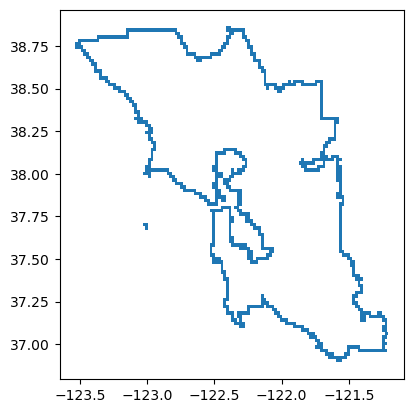

In [7]:
GeoInfo.grid.loc[GeoInfo.grid['position']=='inside']
b.plot(column='position')

,i,j,centroidx,centroidy,area,index,population,with_roads,position,relation_to_line,geometry
0,0,0,-71.718385,41.772821,1.564818,0,0.0,False,outside,not_edge,"POLYGON ((-71.70839 41.78282, -71.70839 41.762..."
1,0,1,-71.718385,41.792821,1.564818,1,0.0,False,outside,not_edge,"POLYGON ((-71.70839 41.80282, -71.70839 41.782..."
2,0,2,-71.718385,41.812821,1.564818,2,0.0,False,outside,not_edge,"POLYGON ((-71.70839 41.82282, -71.70839 41.802..."
3,0,3,-71.718385,41.832821,1.564818,3,0.0,False,outside,not_edge,"POLYGON ((-71.70839 41.84282, -71.70839 41.822..."
4,0,4,-71.718385,41.852821,1.564818,4,0.0,False,outside,not_edge,"POLYGON ((-71.70839 41.86282, -71.70839 41.842..."
...,...,...,...,...,...,...,...,...,...,...,...
3472,60,52,-70.526976,42.812821,0.234302,3472,0.0,False,outside,not_edge,"POLYGON ((-70.52839 42.80282, -70.52839 42.822..."
3473,60,53,-70.526976,42.832821,0.234302,3473,0.0,False,outside,not_edge,"POLYGON ((-70.52839 42.82282, -70.52839 42.842..."
3474,60,54,-70.526976,42.852821,0.234302,3474,0.0,False,outside,not_edge,"POLYGON ((-70.52839 42.84282, -70.52839 42.862..."
3475,60,55,-70.526976,42.872821,0.234302,3475,0.0,False,outside,not_edge,"POLYGON ((-70.52839 42.86282, -70.52839 42.882..."


<Axes: >

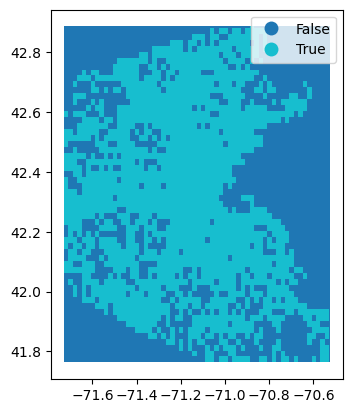